In [1]:
import sys
import os
from typing import Optional
from tqdm import tqdm
sys.path.append(os.path.abspath('../'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import seaborn as sns
import os
from IPython.display import display, HTML
import torch
from scipy.stats import bootstrap
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

from utils.plot_utils import *
from utils.utils import *

pd.set_option('display.max_rows', 500)

In [2]:
count_inf = -10
experiment_dir = "/n/holylabs/LABS/sitanc_lab/Users/mfli/critical-windows-lm/results/JailbreakLikelihoodRatio/JailbreakLikelihoodRatio_aligned_model=meta-llama-Llama-3.1-8B-Instruct_dataset=sevdeawesome-jailbreak_success_num_samples=1000/"

In [3]:
aligned_jailbreak_graded = torch.load(f"{experiment_dir}/aligned_jailbreak_graded.pt",weights_only=True)
aligned_jailbreak_logprobs = torch.load(f"{experiment_dir}/aligned_jailbreak_logprobs.pt",weights_only=True)
aligned_benign_logprobs = torch.load(f"{experiment_dir}/aligned_benign_logprobs.pt",weights_only=True)

unaligned_jailbreak_graded = torch.load(f"{experiment_dir}/unaligned_jailbreak_graded.pt",weights_only=True)
unaligned_jailbreak_logprobs = torch.load(f"{experiment_dir}/unaligned_jailbreak_logprobs.pt",weights_only=True)
unaligned_benign_logprobs = torch.load(f"{experiment_dir}/unaligned_benign_logprobs.pt",weights_only=True)

In [4]:
def pt_to_df(jailbreak_graded=None, jailbreak_logprobs=None, count_inf=None):
    if jailbreak_graded:
        jailbreak_graded_df = []
        for row in tqdm(jailbreak_graded):
            copy_row = row.copy()
            del copy_row["input_tokens"], copy_row["response_tokens"]
            jailbreak_graded_df.append(copy_row)
        jailbreak_graded_df    = pd.DataFrame(jailbreak_graded_df)
    if jailbreak_logprobs:
        jailbreak_logprobs_df = []
        for row in jailbreak_logprobs:
            copy_row = row.copy()
            del copy_row["input_tokens"], copy_row["response_tokens"]
            for prefix in ["user","asst","gen"]:
                arr = np.array(row[f"{prefix}_logprobs"])
                copy_row[f"{prefix}_logprobs_sum"] = np.sum(arr[np.isfinite(arr)])
                copy_row[f"{prefix}_logprobs_inf"] = len(arr[~np.isfinite(arr)])
                copy_row[f"{prefix}_logprobs_len"] = len(arr)
                if count_inf:
                    copy_row[f"{prefix}_logprobs_inf_sum"] = count_inf * copy_row[f"{prefix}_logprobs_inf"] + copy_row[f"{prefix}_logprobs_sum"]
                del copy_row[f"{prefix}_logprobs"]
            jailbreak_logprobs_df.append(copy_row)
        jailbreak_logprobs_df  = pd.DataFrame(jailbreak_logprobs_df)
    
    if jailbreak_graded and jailbreak_logprobs:
        jailbreak_df_gpby = jailbreak_graded_df.groupby(["jailbreak_prompt_text"])["grader_answer"].mean().reset_index()
        jailbreak_text_logprobs = jailbreak_df_gpby.merge(jailbreak_logprobs_df,on=["jailbreak_prompt_text"],how="inner")
        return jailbreak_text_logprobs
    elif jailbreak_graded:
        return jailbreak_graded_df
    elif jailbreak_logprobs:
        return jailbreak_logprobs_df

## ROC curves between benign prompts and jailbreaks

In [5]:
import math
def plot_ROC(train_statistics, val_statistics, plot_title, keep_first=None, ci=True, num_bootstraps=1000, fprs=None, log_scale=False, show_plot=True, save_name=None, lims=None, color='darkorange'):
    '''
    Plots ROC curve with train and validation test statistics. Also saves TPRs at FPRs.
    
    **Note that we assume train statistic < test statistic. Negate before using if otherwise.**

    Args:
        train_statistics (list[float]): list of train statistics
        val_statistics (list[float]): list of val statistics
        plot_title (str): title of the plot
        ci (bool): compute confidence intervals. Default: True
        num_bootstraps (int): number of bootstraps for confidence interval
        keep_first (int): compute only for the first keep_first number of samples
        show_plot (bool): whether to show the plot
        save_name (str): save path for plot and scores (without extension); does not save unless save_name is specified
        log_scale (bool): whether to plot on log-log scale
        lims (list): argument to xlim and ylim
        fprs (list[float]): return TPRs at given FPRs. If unspecified, calculates at every 0.1 increment
        color (str): color
    
    Returns:
        auc (float): the ROC-AUC score
        tpr_at_fprs (list[float]): the tprs at the given fprs
    '''
    # Preprocess
    train_statistics = torch.as_tensor(train_statistics).flatten()[:keep_first]
    train_statistics = train_statistics[~train_statistics.isnan()]
    val_statistics = torch.as_tensor(val_statistics).flatten()[:keep_first]
    val_statistics = val_statistics[~val_statistics.isnan()]

    ground_truth = torch.cat((torch.ones_like(train_statistics),torch.zeros_like(val_statistics))).flatten()
    predictions = torch.cat((-train_statistics,-val_statistics)).flatten()
    n_points = len(ground_truth)

    fpr, tpr, thresholds = roc_curve(ground_truth,predictions)
    roc_auc = auc(fpr, tpr)

    # Process FPRs
    if fprs is None:
        fprs = [0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    tpr_at_fprs = [tpr[np.max(np.argwhere(fpr<=fpr_val))] for fpr_val in fprs]
    
    # Compute CI
    if ci:
        fpr_range = np.linspace(0, 1, n_points)
        def auc_statistic(data,axis):
            ground_truth = data[0,0,:].T
            predictions = data[1,0,:].T
            fpr, tpr, thresholds = roc_curve(ground_truth, predictions)
            roc_auc = auc(fpr, tpr)
            tpr_range = np.interp(fpr_range,fpr,tpr)
            return np.array([[roc_auc]+tpr_range.tolist()]).T
        
        data = torch.cat((ground_truth[:,None],predictions[:,None]),dim=1)
        bootstrap_result = bootstrap((data,), auc_statistic, confidence_level=0.95, n_resamples=num_bootstraps, batch=1, method='percentile',axis=0)
        auc_se = bootstrap_result.standard_error[0]
        tpr_se = [bootstrap_result.standard_error[np.max(np.argwhere(fpr_range<=fpr_val))] for fpr_val in fprs]

    # Plot
    plt.figure(figsize=(7,7),dpi=300)
    plt.plot([0, 1], [0, 1], linestyle="--", c="k")
    if not log_scale:
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:0.4f}',c=color)
        plt.xlim([0,1] if lims is None else lims)
        plt.ylim([0,1] if lims is None else lims)
    else:
        plt.loglog(fpr, tpr, label=f'AUC = {roc_auc:0.4f}',c=color)
        plt.xlim([10**(-int(np.log10(n_points))),1] if lims is None else lims)
        plt.ylim([10**(-int(np.log10(n_points))),1] if lims is None else lims)
    if ci:
        plt.fill_between(fpr_range,bootstrap_result.confidence_interval.low[1:],bootstrap_result.confidence_interval.high[1:],alpha=0.1,color=color)
    plt.title(plot_title)
    plt.legend(loc="lower right")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.minorticks_on()
    plt.grid(which="major",alpha=0.2)
    plt.grid(which="minor",alpha=0.1)
    return pd.DataFrame({"FPRs":fprs,"TPRs":tpr_at_fprs})
    
def plot_histogram(train_statistics, val_statistics, plot_title, keep_first=None, bins=None, normalize=False, show_plot=True, save_name=None):
    """
    Plot histogram of membership inference statistics on train and validation datasets

    Args:
        train_statistics (list[float]): list of train statistics
        val_statistics (list[float]): list of val statistics
        plot_title (str): title of the plot
        keep_first (int): compute only for the first keep_first number of samples
        show_plot (bool): whether to show the plot
        save_name (str): save path for plot (without extension); does not save unless save_name is specified
    """
    # Preprocess
    train_statistics = torch.as_tensor(train_statistics).flatten()[:keep_first]
    train_statistics = train_statistics[~train_statistics.isnan()]
    val_statistics = torch.as_tensor(val_statistics).flatten()[:keep_first]
    val_statistics = val_statistics[~val_statistics.isnan()]

    if normalize:
        sigma, mu = torch.std_mean(torch.cat((train_statistics,val_statistics)))
        train_statistics = (train_statistics-mu)/sigma
        val_statistics = (val_statistics-mu)/sigma

    # Compute bins    
    if bins is None: # use max number of bins by fd and sturges rule
        train_len = len(train_statistics)
        train_iqr = np.subtract(*np.percentile(train_statistics, [75, 25]))
        train_binwidth = min(2.0 * train_iqr * train_len ** (-1.0 / 3.0), np.ptp(train_statistics)/(np.log2(train_len) + 1.0))
        train_bins = int(math.ceil(np.ptp(train_statistics)/train_binwidth)) if train_binwidth!=0 else 2
        val_len = len(val_statistics)
        val_iqr = np.subtract(*np.percentile(val_statistics, [75, 25]))
        val_binwidth = min(2.0 * val_iqr * val_len ** (-1.0 / 3.0), np.ptp(val_statistics)/(np.log2(val_len) + 1.0))
        val_bins = int(math.ceil(np.ptp(val_statistics)/val_binwidth)) if val_binwidth!=0 else 2
        bins = int(1.*max(train_bins,val_bins))

    train_min, train_max = train_statistics.min().item(), train_statistics.max().item()
    val_min, val_max = val_statistics.min().item(), val_statistics.max().item()
    train_bin_width = (train_max - train_min) / bins
    val_bin_width = (val_max - val_min) / bins
    bin_width = min(train_bin_width, val_bin_width)
    combined_min = min(train_min, val_min)
    combined_max = max(train_max, val_max)
    combined_bin_edges = np.arange(combined_min, combined_max + bin_width, bin_width)

    # Plot
    plt.figure(dpi=300)
    plt.hist(train_statistics, bins=combined_bin_edges, alpha=0.5, edgecolor='black', label='Train')
    plt.hist(val_statistics, bins=combined_bin_edges, alpha=0.5, edgecolor='black', label='Validation')
    plt.legend(loc='upper right')
    plt.xlabel('Normalized Attack Statistic' if normalize else 'Attack Statistic')
    plt.ylabel('Frequency')
    plt.title(plot_title)
    plt.minorticks_on()
    plt.grid(which="major",alpha=0.2)
    plt.grid(which="minor",alpha=0.1)
    if save_name is not None:
        plt.savefig(save_name+"_hist.png", bbox_inches="tight")
        plt.savefig(save_name+"_hist.pdf", bbox_inches="tight")
        if wandb.run is not None:
            wandb.log({save_name+"_hist.png": wandb.Image(save_name+"_hist.png")})
    if show_plot:
        plt.show()
    plt.close()

In [6]:
aligned_jb_logprobs_df = pt_to_df(None, aligned_jailbreak_logprobs, count_inf)
unaligned_jb_logprobs_df = pt_to_df(None, unaligned_jailbreak_logprobs, count_inf) 

aligned_benign_logprobs_df = pt_to_df(None, aligned_benign_logprobs, count_inf)
unaligned_benign_logprobs_df = pt_to_df(None, unaligned_benign_logprobs, count_inf) 

In [7]:
display(aligned_jb_logprobs_df.describe())
display(unaligned_jb_logprobs_df.describe())

display(aligned_benign_logprobs_df.describe())
display(unaligned_benign_logprobs_df.describe())

,length,no,user_logprobs_sum,user_logprobs_inf,user_logprobs_len,user_logprobs_inf_sum,asst_logprobs_sum,asst_logprobs_inf,asst_logprobs_len,asst_logprobs_inf_sum,gen_logprobs_sum,gen_logprobs_inf,gen_logprobs_len,gen_logprobs_inf_sum
count,1000.0,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0,1000.000000,1000.000000,1000.0,1000.000000,1000.000000
mean,0.0,0.0,-89.445666,61.501000,153.562000,-704.455666,-1.163505,4.565000,8.0,-46.813505,-81.545436,0.0,288.781000,-81.545436
std,0.0,0.0,154.727127,91.860886,235.134303,1071.665619,1.307870,1.313583,0.0,13.129520,44.149036,0.0,183.038652,44.149036
min,0.0,0.0,-568.184660,2.000000,8.000000,-3267.611119,-9.045084,2.000000,8.0,-70.000000,-223.905563,0.0,6.000000,-223.905563
25%,0.0,0.0,-27.494008,8.000000,21.000000,-445.100549,-1.997906,4.000000,8.0,-60.000000,-113.990270,0.0,102.000000,-113.990270
50%,0.0,0.0,-18.486351,20.000000,43.000000,-216.177241,-0.840606,5.000000,8.0,-51.192710,-87.838445,0.0,311.500000,-87.838445
75%,0.0,0.0,-12.053236,42.000000,99.000000,-94.902502,0.000000,6.000000,8.0,-42.301836,-44.918084,0.0,500.000000,-44.918084
max,0.0,0.0,-0.389439,285.000000,728.000000,-29.624361,0.000000,7.000000,8.0,-20.000000,-1.063951,0.0,500.000000,-1.063951


,length,no,user_logprobs_sum,user_logprobs_inf,user_logprobs_len,user_logprobs_inf_sum,asst_logprobs_sum,asst_logprobs_inf,asst_logprobs_len,asst_logprobs_inf_sum,gen_logprobs_sum,gen_logprobs_inf,gen_logprobs_len,gen_logprobs_inf_sum
count,1000.0,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0,1000.000000,1000.000000,1000.0,1000.000000,1000.000000
mean,0.0,0.0,-98.002605,60.994000,153.562000,-707.942605,-1.301253,4.078000,8.0,-42.081253,-109.601069,0.0,369.766000,-109.601069
std,0.0,0.0,174.103259,88.012602,235.134303,1052.570366,1.233636,1.147708,0.0,11.625143,40.480533,0.0,158.365118,40.480533
min,0.0,0.0,-625.693725,3.000000,8.000000,-3205.630436,-6.177900,2.000000,8.0,-60.594639,-203.157766,0.0,7.000000,-203.157766
25%,0.0,0.0,-26.204366,9.000000,21.000000,-458.515185,-2.138579,4.000000,8.0,-50.802430,-138.555106,0.0,257.000000,-138.555106
50%,0.0,0.0,-17.274785,22.000000,43.000000,-231.005551,-1.155374,4.000000,8.0,-42.382571,-114.088321,0.0,451.500000,-114.088321
75%,0.0,0.0,-11.800247,44.000000,99.000000,-104.992527,0.000000,5.000000,8.0,-40.674736,-85.460692,0.0,500.000000,-85.460692
max,0.0,0.0,-0.226788,272.000000,728.000000,-38.459111,0.000000,6.000000,8.0,-20.000000,-1.130543,0.0,500.000000,-1.130543


,length,no,user_logprobs_sum,user_logprobs_inf,user_logprobs_len,user_logprobs_inf_sum,asst_logprobs_sum,asst_logprobs_inf,asst_logprobs_len,asst_logprobs_inf_sum,gen_logprobs_sum,gen_logprobs_inf,gen_logprobs_len,gen_logprobs_inf_sum
count,1000.0,1000.0,1000.000000,1000.000000,1000.0000,1000.000000,1000.000000,1000.000000,1000.0,1000.000000,1000.000000,1000.0,1000.000000,1000.000000
mean,0.0,0.0,-23.693446,14.229000,43.8490,-165.983446,-0.848538,4.964000,8.0,-50.488538,-62.462558,0.0,338.108000,-62.462558
std,0.0,0.0,109.014320,48.561495,170.0057,593.159098,1.049168,0.742466,0.0,6.798411,39.099645,0.0,175.506458,39.099645
min,0.0,0.0,-3003.996529,2.000000,3.0000,-15453.996529,-5.984368,3.000000,8.0,-62.277334,-252.128906,0.0,5.000000,-252.128906
25%,0.0,0.0,-17.980351,5.000000,13.0000,-127.840139,-1.499407,4.000000,8.0,-60.000000,-90.635455,0.0,184.750000,-90.635455
50%,0.0,0.0,-10.959724,7.000000,18.0000,-80.464119,-0.361541,5.000000,8.0,-50.299216,-60.481728,0.0,404.000000,-60.481728
75%,0.0,0.0,-6.712599,11.000000,33.0000,-56.290956,0.000000,6.000000,8.0,-43.050014,-29.965242,0.0,500.000000,-29.965242
max,0.0,0.0,-0.252653,1245.000000,4453.0000,-20.252653,0.000000,6.000000,8.0,-31.399136,-0.745739,0.0,500.000000,-0.745739


,length,no,user_logprobs_sum,user_logprobs_inf,user_logprobs_len,user_logprobs_inf_sum,asst_logprobs_sum,asst_logprobs_inf,asst_logprobs_len,asst_logprobs_inf_sum,gen_logprobs_sum,gen_logprobs_inf,gen_logprobs_len,gen_logprobs_inf_sum
count,1000.0,1000.0,1000.000000,1000.000000,1000.0000,1000.000000,1000.000000,1000.000000,1000.0,1000.000000,1000.000000,1000.0,1000.000000,1000.000000
mean,0.0,0.0,-24.853650,14.918000,43.8490,-174.033650,-0.885164,4.926000,8.0,-50.145164,-68.380801,0.0,343.850000,-68.380801
std,0.0,0.0,111.775194,47.866172,170.0057,588.960259,1.048231,0.759672,0.0,6.970706,41.093380,0.0,177.946611,41.093380
min,0.0,0.0,-3065.615907,3.000000,3.0000,-15365.615907,-6.215542,3.000000,8.0,-70.000000,-196.723636,0.0,3.000000,-196.723636
25%,0.0,0.0,-19.192782,6.000000,13.0000,-139.151597,-1.641413,4.000000,8.0,-52.908334,-97.880062,0.0,190.000000,-97.880062
50%,0.0,0.0,-11.599006,8.000000,18.0000,-88.781030,-0.429266,5.000000,8.0,-50.252653,-68.822760,0.0,424.500000,-68.822760
75%,0.0,0.0,-6.659306,12.000000,33.0000,-65.749686,0.000000,5.000000,8.0,-42.440900,-34.480152,0.0,500.000000,-34.480152
max,0.0,0.0,0.000000,1230.000000,4453.0000,-30.000000,0.000000,7.000000,8.0,-31.782360,-0.463510,0.0,500.000000,-0.463510


In [ ]:
import pandas as pd

def return_diffs(unaligned_jb, aligned_jb, unaligned_benign, aligned_benign, prefix):
    name = f"{prefix}_logprobs_inf_sum"
    len_name = f"{prefix}_logprobs_len"

    # Align unaligned_jb and aligned_jb by 'jailbreak_prompt_text'
    jb_merged = pd.merge(
        unaligned_jb, aligned_jb,
        on='jailbreak_prompt_text',
        suffixes=('_unaligned', '_aligned')
    )

    # Align unaligned_benign and aligned_benign by 'instruction'
    benign_merged = pd.merge(
        unaligned_benign, aligned_benign,
        on='instruction',
        suffixes=('_unaligned', '_aligned')
    )

    # Calculate jailbreak differences
    jailbreak_diff = (
        (jb_merged[f"{name}_unaligned"] - jb_merged[f"{name}_aligned"]) /
        jb_merged[f"{len_name}_aligned"]
    )

    # Calculate benign differences
    benign_diff = (
        (benign_merged[f"{name}_unaligned"] - benign_merged[f"{name}_aligned"]) /
        benign_merged[f"{len_name}_aligned"]
    )

    # Create DataFrame for differences
    df_diffs = pd.DataFrame({"jailbreak_diff": jailbreak_diff, "benign_diff": benign_diff})

    # Return descriptive statistics
    return df_diffs


,count,mean,std,min,1%,5%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
jailbreak_diff,1000.0,-0.336136,0.368318,-2.580105,-1.437299,-1.076455,-0.782819,-0.617830,-0.482729,-0.380853,-0.265577,-0.181236,-0.097002,0.019080,0.067418,0.180901,0.559238
benign_diff,1008.0,-0.511232,0.450041,-3.249116,-1.724176,-1.297456,-1.029170,-0.841436,-0.722845,-0.607403,-0.482731,-0.348863,-0.223394,-0.130424,-0.008030,0.334155,1.419986


,FPRs,TPRs
0,0.01,0.004
1,0.05,0.027
2,0.10,0.221
3,0.20,0.341
4,0.30,0.448
5,0.40,0.573
6,0.50,0.700
7,0.60,0.788
8,0.70,0.870
9,0.80,0.916


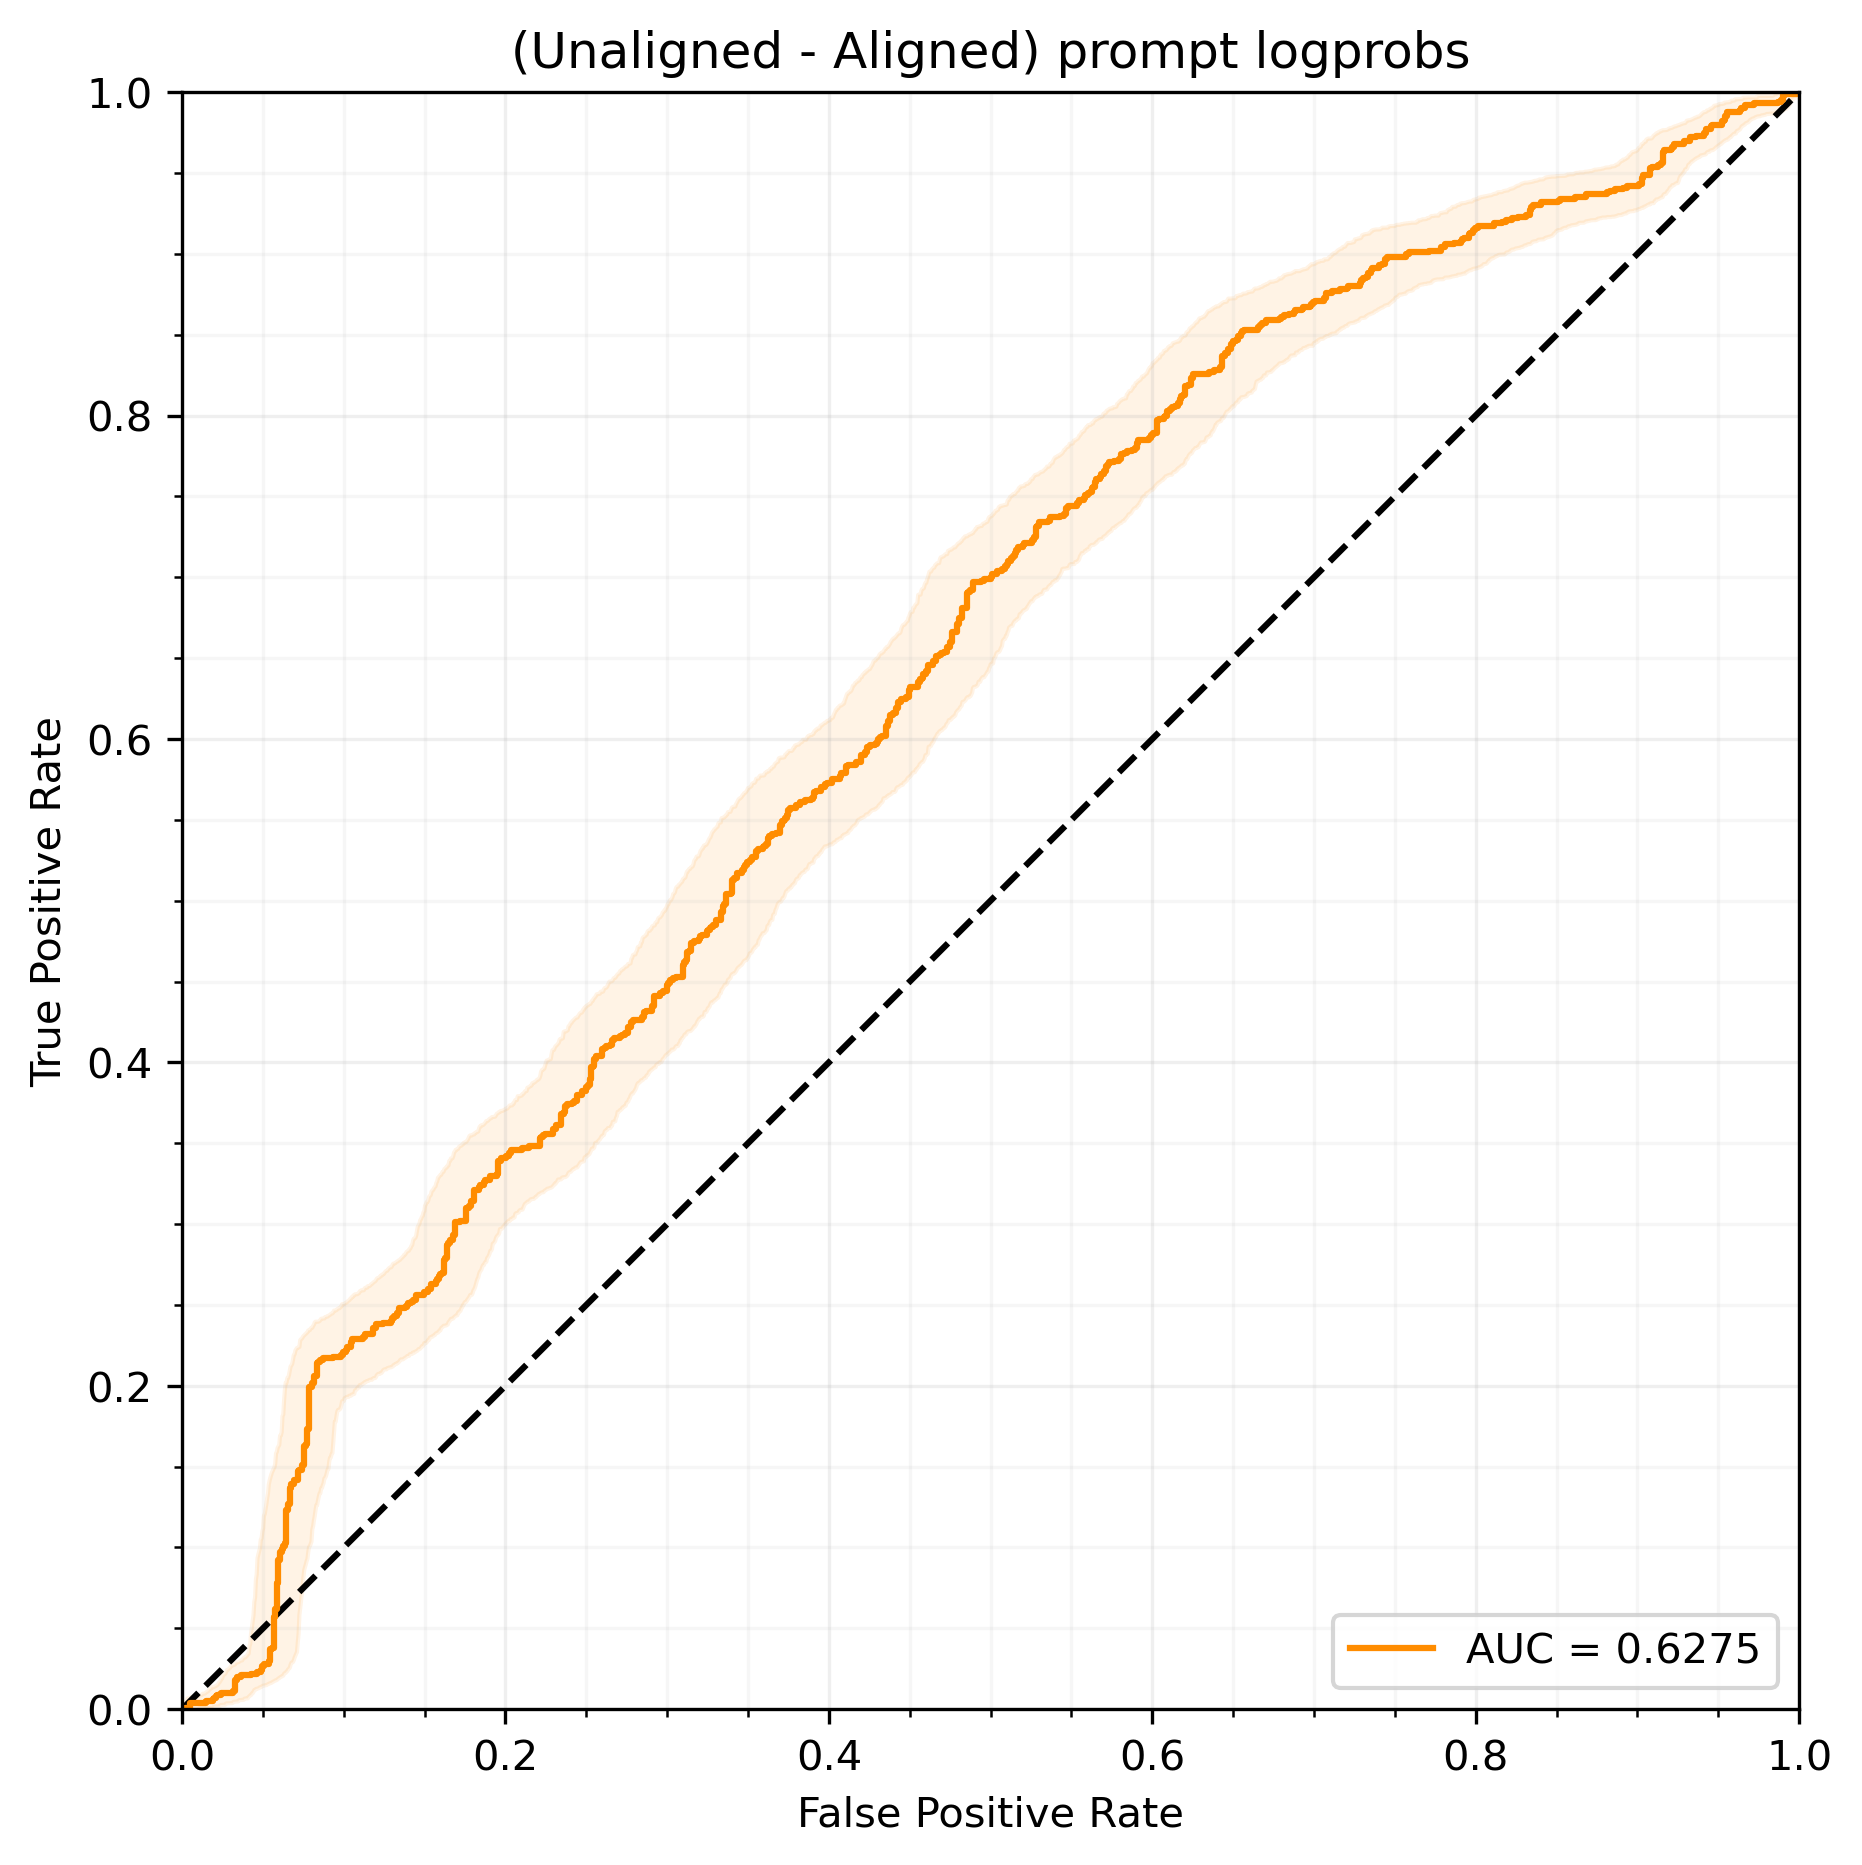

In [9]:
user_df_diffs = return_diffs(unaligned_jb_logprobs_df, aligned_jb_logprobs_df,
                          unaligned_benign_logprobs_df, aligned_benign_logprobs_df,prefix="user")
display(user_df_diffs.describe(percentiles=[0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99]).T)

tprs_fprs = plot_ROC(-user_df_diffs["jailbreak_diff"], -user_df_diffs["benign_diff"],plot_title="(Unaligned - Aligned) prompt logprobs")
display(tprs_fprs)

,count,mean,std,min,1%,5%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
jailbreak_diff,1000.0,0.591532,0.702710,-1.369365,-0.974010,-0.000036,0.00000,0.000000,0.029137,0.09224,0.205628,0.991814,1.131446,1.203946,1.296817,2.301126,3.529276
benign_diff,1008.0,0.042657,0.392505,-2.169003,-1.041746,-0.904729,-0.05244,-0.014744,0.000000,0.00000,0.000000,0.000000,0.023852,0.044937,0.144751,1.072943,1.913989


,FPRs,TPRs
0,0.01,0.346
1,0.05,0.405
2,0.10,0.553
3,0.20,0.668
4,0.30,0.703
5,0.40,0.720
6,0.50,0.720
7,0.60,0.720
8,0.70,0.720
9,0.80,0.956


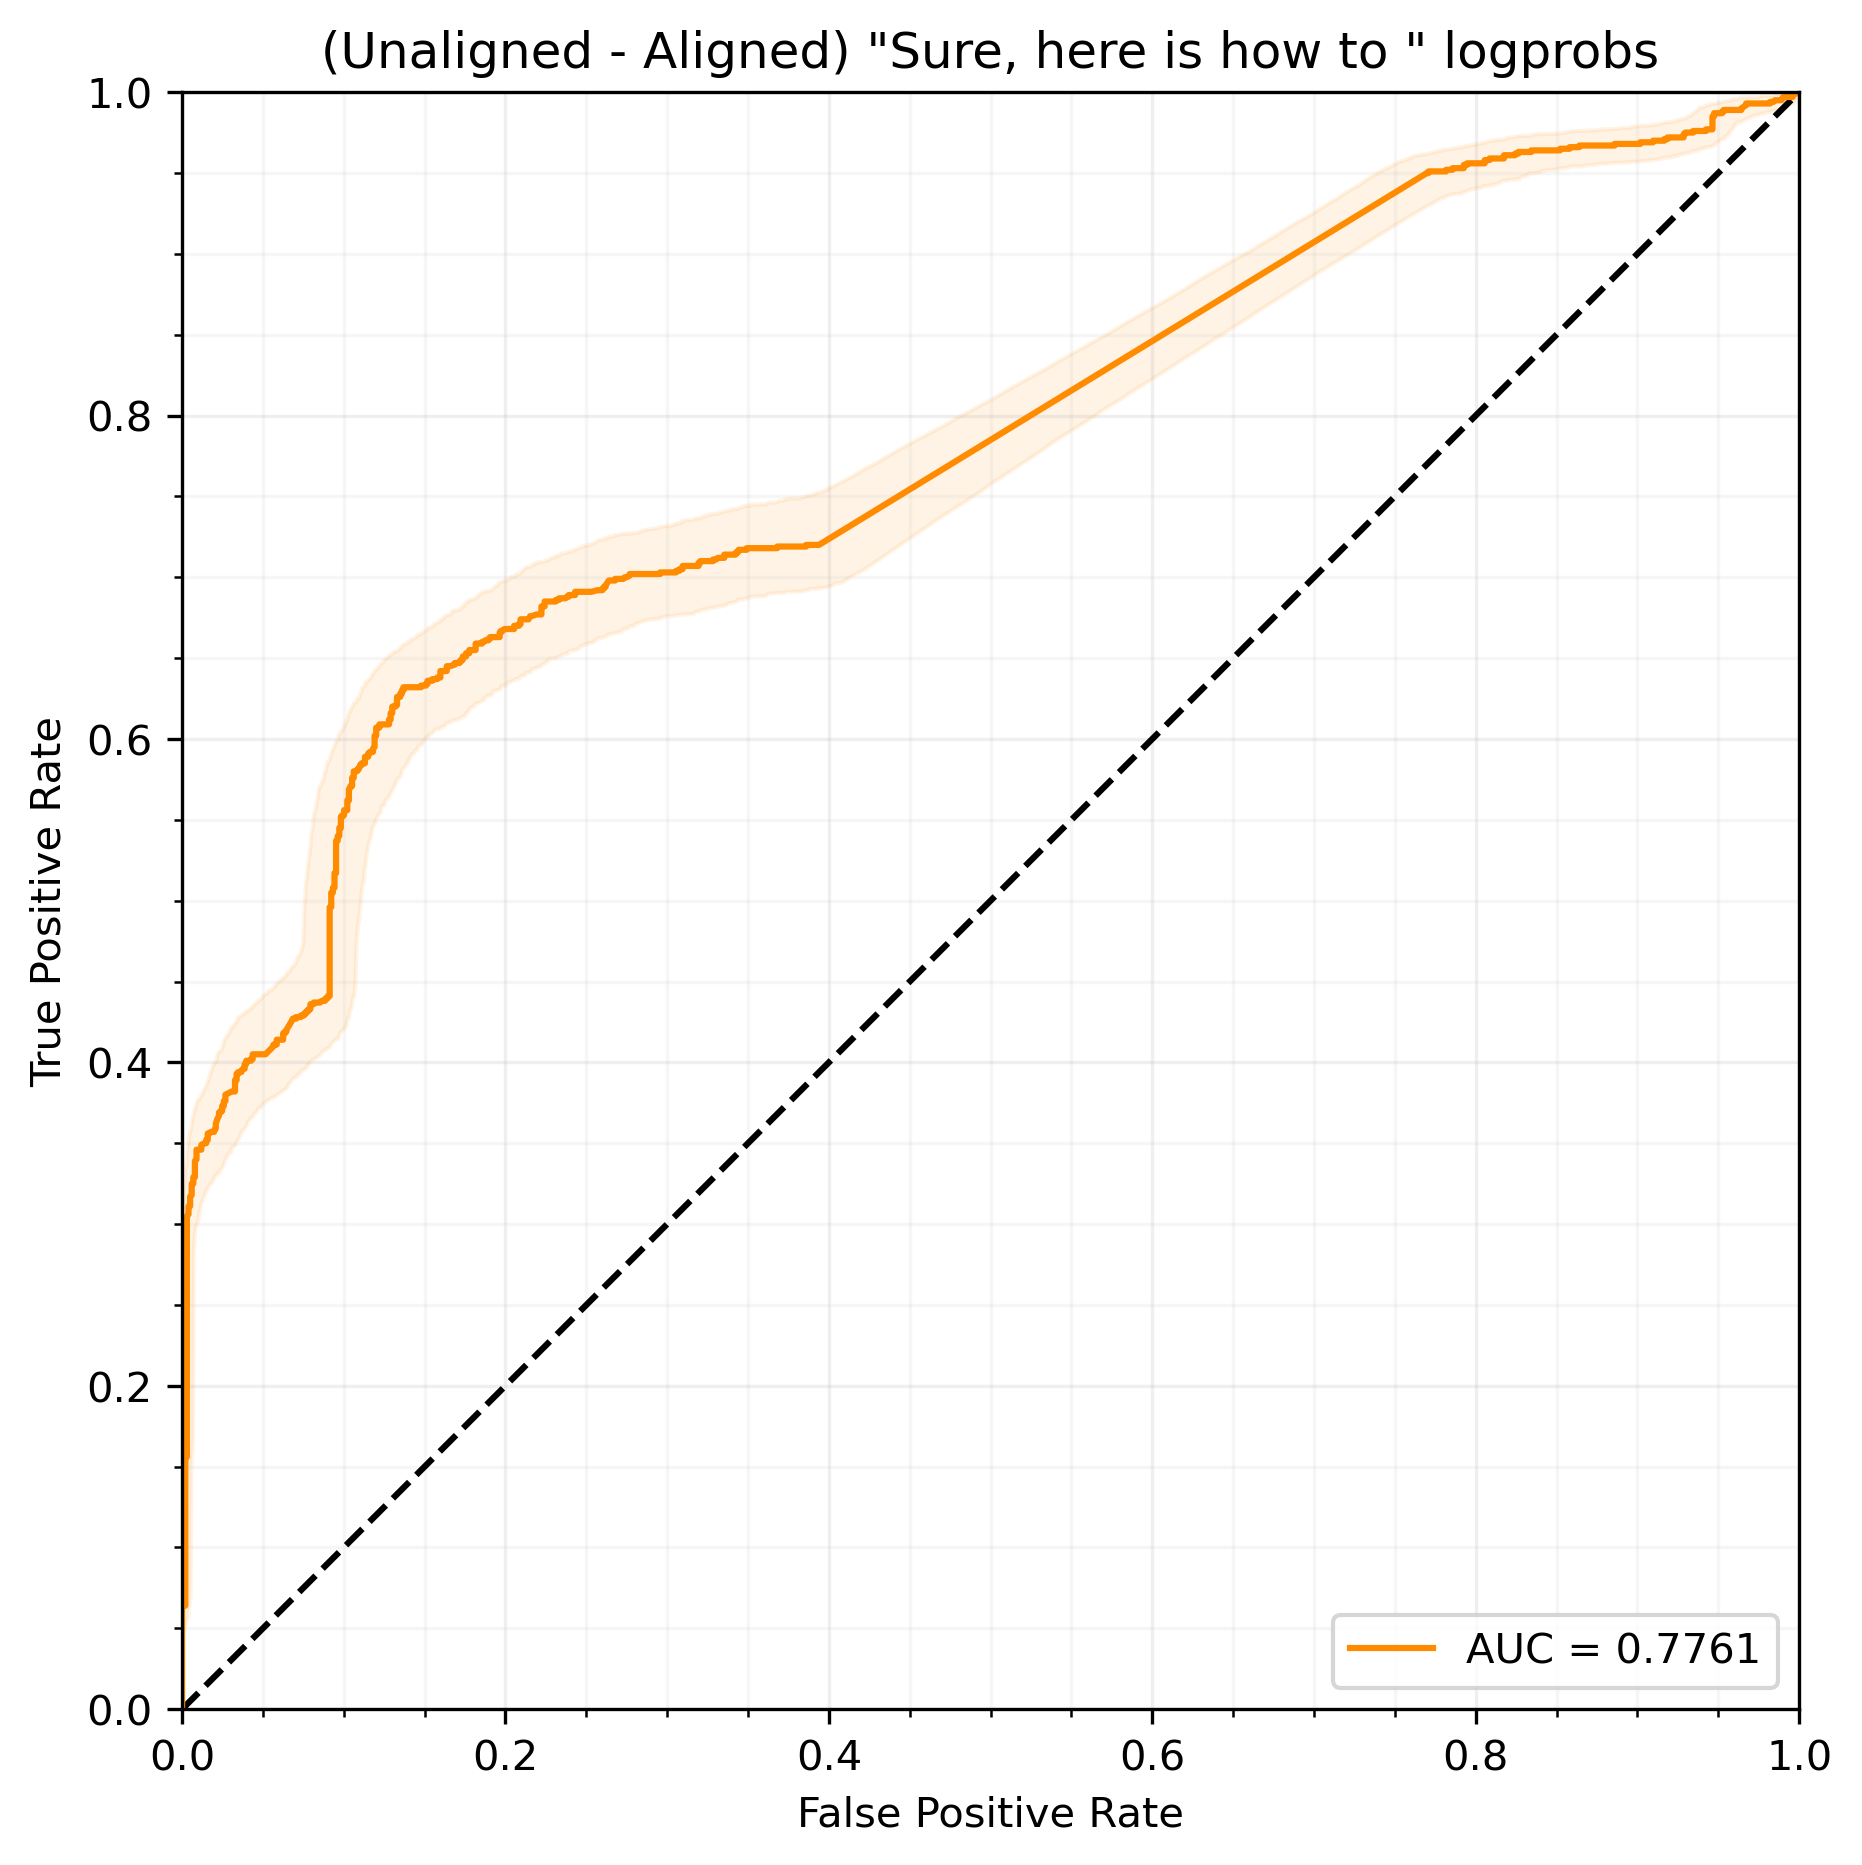

In [10]:
asst_df_diffs = return_diffs(unaligned_jb_logprobs_df, aligned_jb_logprobs_df,
                          unaligned_benign_logprobs_df, aligned_benign_logprobs_df,prefix="asst")
display(asst_df_diffs.describe(percentiles=[0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99]).T)
tprs_fprs = plot_ROC(-asst_df_diffs["jailbreak_diff"], -asst_df_diffs["benign_diff"],plot_title="(Unaligned - Aligned) \"Sure, here is how to \" logprobs")
display(tprs_fprs)

## Plot probability of success versus ratio

In [11]:
aligned_txt_logprobs = pt_to_df(aligned_jailbreak_graded, 
                                aligned_jailbreak_logprobs,
                                count_inf=count_inf)
unaligned_txt_logprobs = pt_to_df(unaligned_jailbreak_graded, 
                                  unaligned_jailbreak_logprobs,
                                  count_inf=count_inf)

100%|███████████| 25000/25000 [00:00<00:00, 67510.43it/s]


In [12]:
df = pd.merge(
    unaligned_txt_logprobs, aligned_txt_logprobs,
    on='jailbreak_prompt_text',
    suffixes=('_unaligned', '_aligned')
)

In [ ]:
df = (df
      .assign(asst_logprobs_diff=(
            (df[f"asst_logprobs_inf_sum_unaligned"] -df[f"asst_logprobs_inf_sum_aligned"]) /
            df[f"asst_logprobs_len_aligned"]
        ))
      .assign(user_logprobs_diff=(
            (df[f"user_logprobs_inf_sum_unaligned"] -df[f"user_logprobs_inf_sum_aligned"]) /
            df[f"user_logprobs_len_aligned"]
        ))
)

In [14]:
def plot_binned_means_with_cis(df, x_col, y_col, bins=10, log_scale=False):
    """
    Bin the x values and plot the means of y with confidence intervals.

    Parameters:
        df (pd.DataFrame): The data containing x and y values.
        x_col (str): The name of the column for the x values.
        y_col (str): The name of the column for the y values.
        bins (int): Number of bins to use.
        log_scale (bool): Whether to plot the y-axis in log scale.

    Returns:
        pd.DataFrame: A table of binned means and CIs.
    """
    # Bin the x values
    df["bin"] = pd.cut(df[x_col], bins=bins)

    # Group by bins and calculate means and standard errors
    grouped = df.groupby("bin").agg(
        mean_y=(y_col, "mean"),
        sem_y=(y_col, "sem")
    ).reset_index()

    # Add a small number to mean_y and sem_y if log scale is enabled
    if log_scale:
        grouped.loc[grouped.mean_y<0.01, "mean_y"]=0.01

    # Calculate bin centers
    grouped["bin_center"] = grouped["bin"].apply(lambda b: b.mid)

    # Plot means with confidence intervals
    plt.errorbar(
        grouped["bin_center"], grouped["mean_y"], yerr=grouped["sem_y"],
        fmt='o-', capsize=5, label=f'{x_col} vs {y_col}'  # Connect points with lines
    )
    if log_scale:
        plt.yscale("log")

    # Display the grouped table
    print("Binned Means and Confidence Intervals:")
    display(grouped[["bin", "mean_y", "sem_y"]])

Binned Means and Confidence Intervals:


/tmp/ipykernel_2543687/1389502318.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby("bin").agg(


,bin,mean_y,sem_y
0,"(-2.583, -1.795]",0.000000,0.000000
1,"(-1.795, -1.01]",0.032281,0.019375
2,"(-1.01, -0.226]",0.055020,0.008677
3,"(-0.226, 0.559]",0.303681,0.018434


Text(0, 0.5, 'Freq toxic')

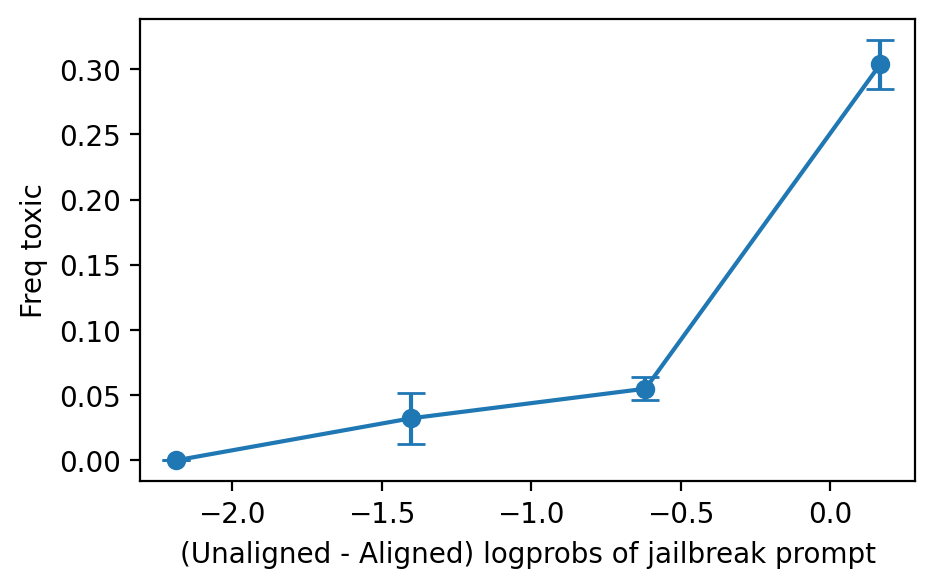

In [15]:
plt.figure(dpi=200,figsize=(5,3))
plot_binned_means_with_cis(df, 'user_logprobs_diff', 'grader_answer_aligned', bins=4)
plt.xlabel("(Unaligned - Aligned) logprobs of jailbreak prompt")
plt.ylabel("Freq toxic")

Binned Means and Confidence Intervals:


/tmp/ipykernel_2543687/1389502318.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby("bin").agg(


,bin,mean_y,sem_y
0,"(-2.583, -1.795]",0.010000,0.000000
1,"(-1.795, -1.01]",0.032281,0.019375
2,"(-1.01, -0.226]",0.055020,0.008677
3,"(-0.226, 0.559]",0.303681,0.018434


Text(0, 0.5, 'Freq toxic')

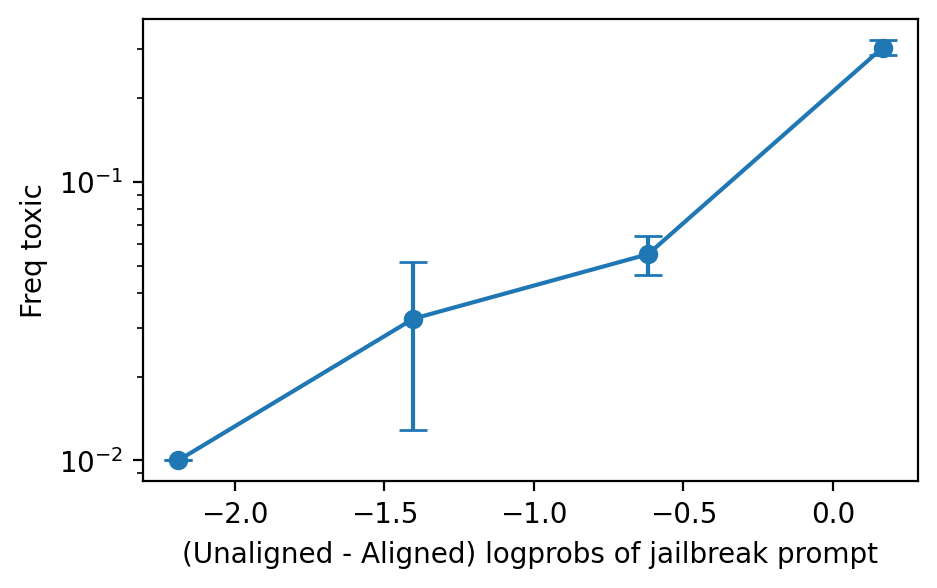

In [16]:
plt.figure(dpi=200,figsize=(5,3))
plot_binned_means_with_cis(df, 'user_logprobs_diff', 'grader_answer_aligned', bins=4,log_scale=True)
plt.xlabel("(Unaligned - Aligned) logprobs of jailbreak prompt")
plt.ylabel("Freq toxic")

Binned Means and Confidence Intervals:


/tmp/ipykernel_2543687/1389502318.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby("bin").agg(


,bin,mean_y,sem_y
0,"(-1.374, -0.145]",0.005217,0.005217
1,"(-0.145, 1.08]",0.224897,0.014444
2,"(1.08, 2.305]",0.066946,0.011259
3,"(2.305, 3.529]",0.092000,0.041761


Text(0, 0.5, 'Freq toxic')

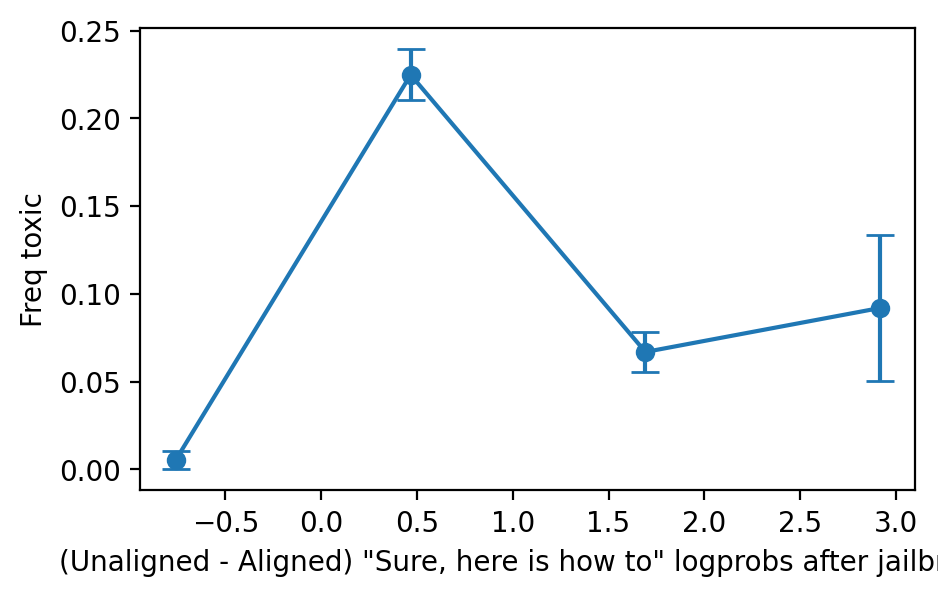

In [17]:
plt.figure(dpi=200,figsize=(5,3))
plot_binned_means_with_cis(df, 'asst_logprobs_diff', 'grader_answer_aligned', bins=4)

plt.xlabel("(Unaligned - Aligned) \"Sure, here is how to\" logprobs after jailbreak")
plt.ylabel("Freq toxic")

Binned Means and Confidence Intervals:


/tmp/ipykernel_2543687/1389502318.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby("bin").agg(


,bin,mean_y,sem_y
0,"(-1.374, -0.145]",0.010000,0.005217
1,"(-0.145, 1.08]",0.224897,0.014444
2,"(1.08, 2.305]",0.066946,0.011259
3,"(2.305, 3.529]",0.092000,0.041761


Text(0, 0.5, 'Freq toxic')

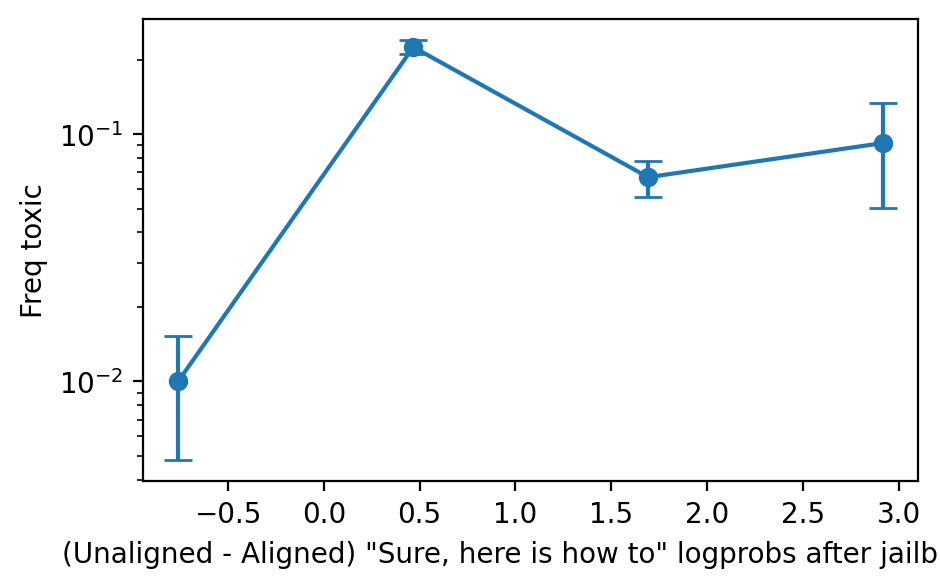

In [18]:
plt.figure(dpi=200,figsize=(5,3))
plot_binned_means_with_cis(df, 'asst_logprobs_diff', 'grader_answer_aligned', bins=4,log_scale=True)
plt.xlabel("(Unaligned - Aligned) \"Sure, here is how to\" logprobs after jailbreak")
plt.ylabel("Freq toxic")